# Language_Detection

Celem projektu jest automatyczne rozpoznawanie języka tekstu na podstawie krótkich próbek. Model został wytrenowany na zbiorze danych zawierającym teksty w 17 językach, z wykorzystaniem technik NLP (TF-IDF) i algorytmu klasyfikacyjnego.

In [3]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

## Wczytywanie danych

In [5]:
data = pd.read_csv("..\input\Sample_Language.csv")

In [6]:
data.head()

,Unnamed: 0,Text,Language
0,0,NaN,English
1,1,Wikipedia[c] is a free-content online encyclop...,English
2,2,"Initially available only in English, Wikipedia...",English
3,3,Wikipedia has been praised for enabling the de...,English
4,4,Various collaborative online encyclopedias wer...,English


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8161 entries, 0 to 8160
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  8161 non-null   int64 
 1   Text        7988 non-null   object
 2   Language    8161 non-null   object
dtypes: int64(1), object(2)
memory usage: 191.4+ KB


In [8]:
data.isnull().sum()


Unnamed: 0      0
Text          173
Language        0
dtype: int64

In [9]:
data = data.dropna(subset=['Text'])

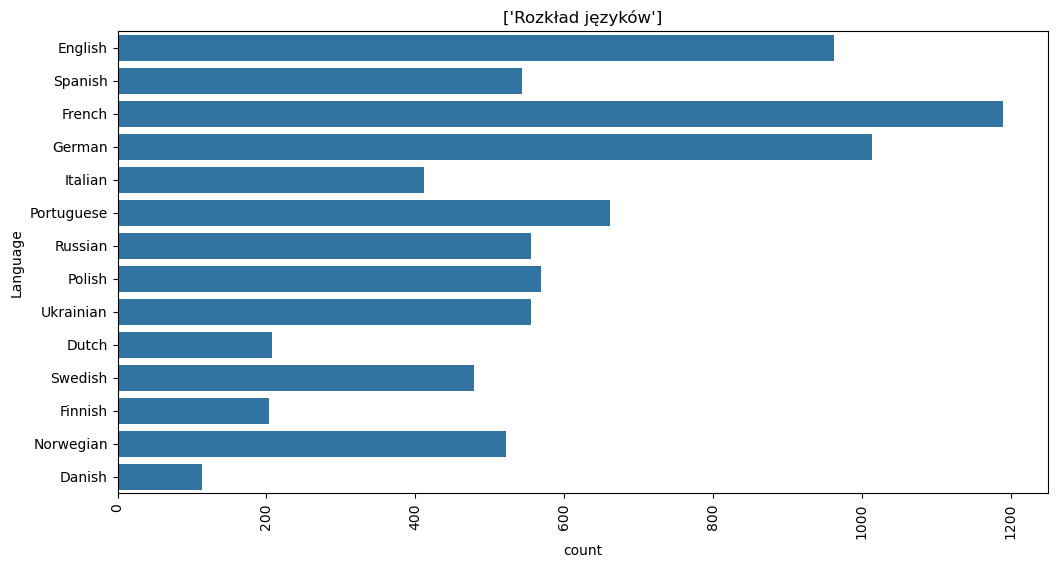

In [10]:
plt.figure(figsize=(12,6))
sns.countplot(data['Language'])
plt.title(['Rozkład języków'])
plt.xticks(rotation= 90)
plt.show()

In [11]:
data['Language'].value_counts()

Language
French        1190
German        1014
English        962
Portuguese     661
Polish         569
Russian        555
Ukrainian      555
Spanish        543
Norwegian      522
Swedish        479
Italian        412
Dutch          208
Finnish        204
Danish         114
Name: count, dtype: int64

## Preprocessing

In [13]:
def clean_text(text):
    text = re.sub(r'[!@#$(),\n"%^*?\:;~`0-9]', ' ', text) # zastepuje wszystkie wymienione znaki spacja
    text = re.sub(r'[\[\]]', ' ', text) # zastepuje nawiasy kwadratowe spacją
    return text.lower()

In [14]:
data["Text"] = data["Text"].apply(clean_text)

In [15]:
data.sample(10)

,Unnamed: 0,Text,Language
6256,6256,теоретичні досягнення в -му століття привели...,Ukrainian
2758,2758,am . januar feierte die wikipedia ihr z...,German
3778,3778,wikipedia è pubblicata in lingue diverse ...,Italian
2086,2086,d'autres procédures sont développées et testée...,French
1521,1521,pour les articles homonymes voir wp et wikipe...,French
7244,7244,microsoft producerar även office till apples m...,Swedish
3071,3071,m | amazon | american express | amgen | apple...,German
2282,2282,il y a plusieurs façons de retenir les décimal...,French
6003,6003,bracia dassler produkowali buty sportowe. z ge...,Polish
3889,3889,quella che segue è una lista parziale delle co...,Italian


## Rozdzielenie danych

In [17]:
X = data["Text"]
y = data["Language"]

## Zamiana zmiennych kategorialnych na numeryczne

In [19]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

## Walidacja danych

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

## Torby słów

TfidfVectorizer służy do konwersji danych teskowych na cechy numeryczne które bierze pod uwage:
- Unigramy (pojedyncze słowa, np. "Harry", "Potter")
- Bigramy (pary słów, np. "Harry Potter", "Potter i")


In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer


In [24]:
tfidf = TfidfVectorizer(ngram_range=(1,2))
tfidf.fit(X_train)
x_train = tfidf.transform(X_train).toarray()
x_test = tfidf.transform(X_test).toarray()


In [25]:
print(x_train.shape)
print(x_test.shape)


(6390, 243396)
(1598, 243396)


## Budowanie modelu 

Model którego uzyje to klasyfikator bayesowski, a konkretnie jego wariant dla cech dyskretnych – Multinomial Naive Bayes (MultinomialNB).
MultinomialNB wykorzystuje twierdzenie Bayesa z założeniem (tzw. "naive" – naiwnym) o niezależności cech. Model ten jest szczególnie przydatny przy danych, gdzie cechy mają charakter dyskretny, np. liczby wystąpień słów w dokumentach.
Jest często wykorzystywany do zadań takich jak filtrowanie spamu, analiza sentymentu czy kategoryzacja dokumentów.

In [28]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [29]:
model = MultinomialNB()
params = {'alpha':[0.01,0.1,0.5,1]}


In [30]:
grid_search = GridSearchCV(model, param_grid= params, cv=5, scoring= 'accuracy')

In [31]:
grid_search.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid={'alpha': [0.01, 0.1, 0.5, 1]}, scoring='accuracy')

In [32]:
best_model = grid_search.best_estimator_

In [33]:
results = pd.DataFrame(grid_search.cv_results_)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,4.632983,2.292146,0.411477,0.024550,0.01,{'alpha': 0.01},0.982003,0.982786,0.985133,0.975743,0.982786,0.981690,0.003153,1
1,3.290851,0.036113,0.401949,0.010041,0.10,{'alpha': 0.1},0.977308,0.976526,0.976526,0.968701,0.971831,0.974178,0.003356,2
2,3.171099,0.037091,0.393666,0.006585,0.50,{'alpha': 0.5},0.955399,0.954617,0.949922,0.946009,0.942879,0.949765,0.004834,3
3,3.162568,0.049600,0.402747,0.015033,1.00,{'alpha': 1},0.926448,0.931142,0.927230,0.920188,0.917058,0.924413,0.005085,4


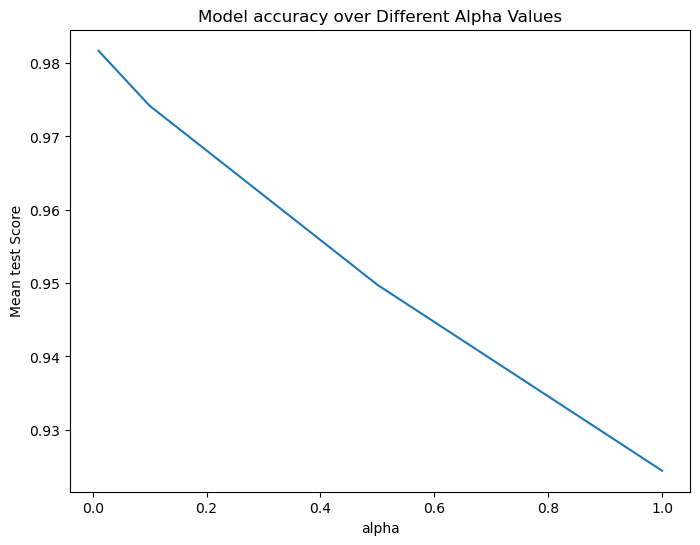

In [34]:
plt.figure(figsize=(8,6))
sns.lineplot(x='param_alpha', y= 'mean_test_score', data=results)
plt.title('Model accuracy over Different Alpha Values')
plt.xlabel('alpha')
plt.ylabel('Mean test Score')
plt.show()

Wartościach alfa wizualizacja dokładności modelu na róznych wartościach hiperparametru alpha w celu zidentyfikowania optymalnej wartosci

In [36]:
y_pred = best_model.predict(x_test)

## Ocena modelu 

In [38]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Generate classification report
class_report = classification_report(y_test, y_pred)

# Display evaluation metrics
print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

Accuracy: 0.9849812265331664
Confusion Matrix:
[[ 21   0   0   0   0   0   0   5   0   0   0   0   0   0]
 [  0  49   0   0   1   1   0   0   0   0   0   0   0   0]
 [  0   0 211   0   0   0   0   0   0   2   0   0   0   0]
 [  0   0   0  29   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0 242   0   0   0   0   0   0   0   0   0]
 [  0   0   1   0   2 202   0   0   0   0   0   0   0   0]
 [  0   0   0   0   1   0  77   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0  94   0   0   0   0   0   0]
 [  0   0   0   0   4   1   1   0  98   0   0   0   0   0]
 [  0   0   3   0   0   0   0   0   0 124   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0 123   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0  95   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  90   0]
 [  0   0   0   0   1   0   0   0   0   0   1   0   0 119]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.81      0.89     

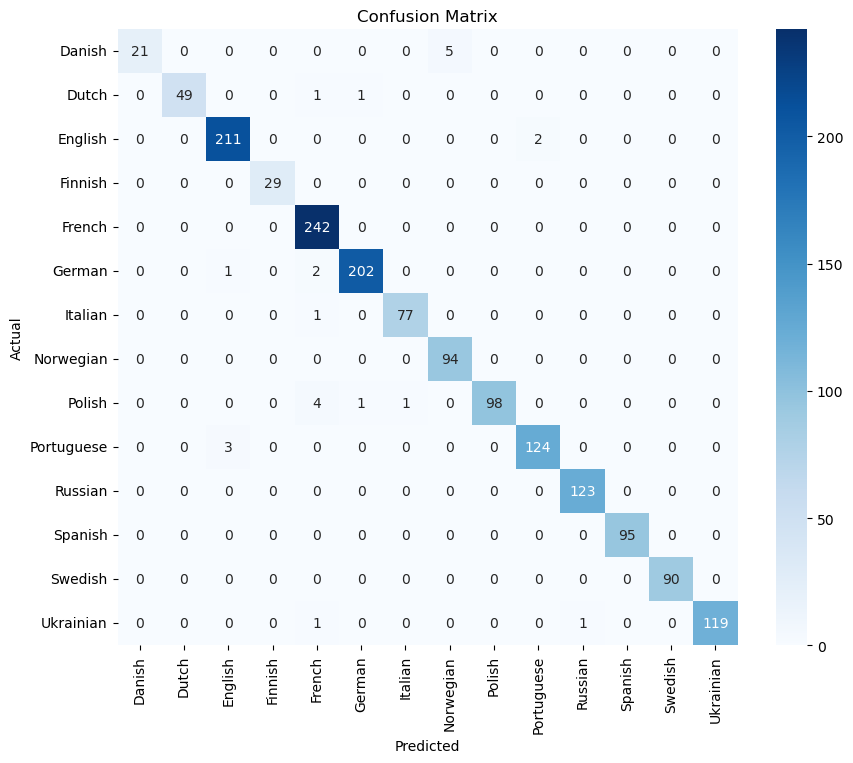

In [39]:
plt.figure(figsize=(10,8))
sns.heatmap(conf_matrix,annot= True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Model Deployment

### Tworzenie Potoku

In [42]:
from sklearn.pipeline import Pipeline

In [43]:
pipeline = Pipeline([
    ('vectorizer', tfidf),
    ('multinomialNB', best_model)
])
pipeline.fit(X_train,y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer(ngram_range=(1, 2))),
                ('multinomialNB', MultinomialNB(alpha=0.01))])

Potok ten obejmuje wektoryzator tfidf i najlepszy model multinomialNB dopasują sie do potoku na danych treningowych.
Potok łączy preprocessing (TF-IDF) i model w jeden obiekt, co upraszcza kod i eliminuje ryzyko błędów.

## Zapisywanie modelu 

In [ ]:
with open('..\app\model\Pipeline_and_model_Language_Detection-0.1.0.pkl', 'wb') as file:
    pickle.dump(pipeline, file)

# TEST MODELU

In [73]:
text = 'hello how are you'
y= pipeline.predict([text])
print(le.classes_[y[0]],y)

English [2]


In [103]:
text = 'czesc jak sie masz'
y= pipeline.predict([text])
print(le.classes_[y[0]],y)

Polish [8]


In [111]:
text = 'ciao dovè il negozio'
y= pipeline.predict([text])
print(le.classes_[y[0]],y)

Italian [6]


In [77]:
text = 'Как вы' # jak sie masz
y= pipeline.predict([text])
print(le.classes_[y[0]],y)

Russian [10]


In [101]:
text = 'hallo, wo ist der Laden' # jak sie masz
y= pipeline.predict([text])
print(le.classes_[y[0]],y)

German [5]


In [79]:
text = 'Como vai' # jak sie masz
y= pipeline.predict([text])
print(le.classes_[y[0]],y)

Portuguese [9]


# Model Poprawnie rozpoznaje języki